In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pycbc
import gwpy

%matplotlib inline

/home/jerry/micromamba/envs/glitch-classification/lib/python3.10/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


## Fourier Transformation

In [2]:
def base_wav(
    wave:str,
    start:float,
    end:float,
    amp:float=1,
    f:float=1,
    phase_shift:float=0,
    fs:int=1024,
):
    times = np.arange(start, end, 1/fs)
    phase = 2*np.pi*f * times
    if wave == 'sin':
        wav = amp * np.sin(phase + phase_shift)
    if wave == 'cos':
        wav = amp * np.cos(phase + phase_shift)
    return times, wav

def signal(
    start:float,
    end:float,
    amplitudes:dict,
    modes:dict,
    phases:dict,
    fs:int=1024,
):
    times = np.arange(start, end, 1/fs) 
    signal = np.zeros(len(times))
    for wave in ('sin', 'cos'):
        if len(amplitudes[wave]) != 0 \
        and len(modes[wave]) != 0 \
        and len(phases[wave]) != 0:
            for amp, f, phase_shift in zip(amplitudes[wave], modes[wave], phases[wave]):
                _, sig = base_wav(
                    wave=wave,
                    start=start,
                    end=end,
                    amp=amp,
                    f=f,
                    phase_shift=phase_shift,
                    fs=fs,
                )
                signal += sig

    return times, signal

def gaussian(
    start:float,
    end:float,
    loc:float=0,
    scale:float=1,
    fs:int=1024,
):
    times = np.arange(start, end, 1/fs)
    signal = np.random.normal(loc=loc, scale=scale, size=len(times))
    return times, signal

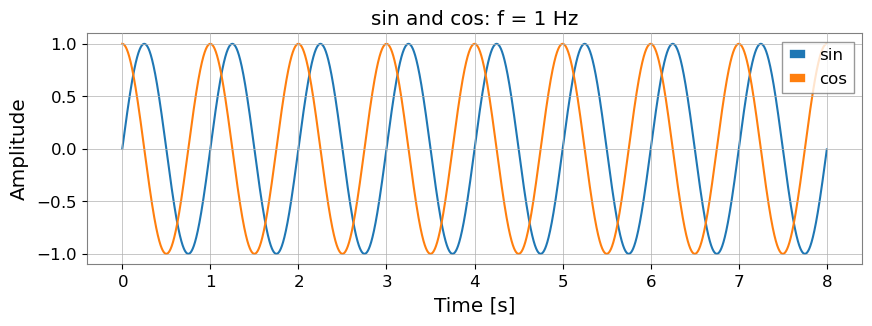

In [3]:
start = 0
end = 8
amp = 1
f = 1
phase_shift = 0
fs = 1024
times_sin, sin_wave = base_wav(
    wave='sin',
    start=start,
    end=end,
    amp=amp,
    f=f,
    phase_shift=phase_shift,
    fs=fs,
)
times_cos, cos_wave = base_wav(
    wave='cos',
    start=start,
    end=end,
    amp=amp,
    f=f,
    phase_shift=phase_shift,
    fs=fs,
)

plt.figure(figsize=[10,3])
plt.title(f"sin and cos: f = {f} Hz")
plt.plot(times_sin, sin_wave, label='sin')
plt.plot(times_cos, cos_wave, label='cos')
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

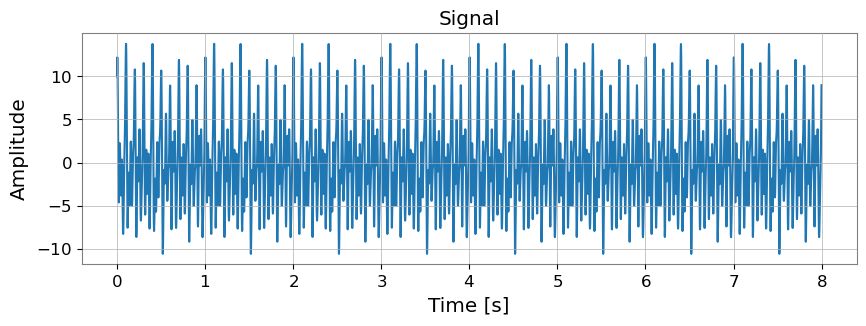

In [4]:
amplitudes = {
    "cos":[3, 5, 2],
    "sin":[1, 2, 3],
}
modes = {
    "cos":[10, 20, 30],
    "sin":[11, 13, 40],
}
phases = {
    "cos":[0, 0, 0],
    "sin":[0, 0, 0],
}

times, sig = signal(
    start=0,
    end=8,
    amplitudes=amplitudes,
    modes=modes,
    phases=phases,
)
plt.figure(figsize=[10,3])
plt.title(f"Signal")
plt.plot(times, sig)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

4097
[-1.23332455e-11+0.00000000e+00j -4.32002369e-12+2.05246576e-13j
 -5.54107772e-12-1.16848990e-12j ...  5.96869311e-12-1.01551730e-12j
 -1.70562691e-12-1.80670180e-12j  1.48325796e-12+0.00000000e+00j]


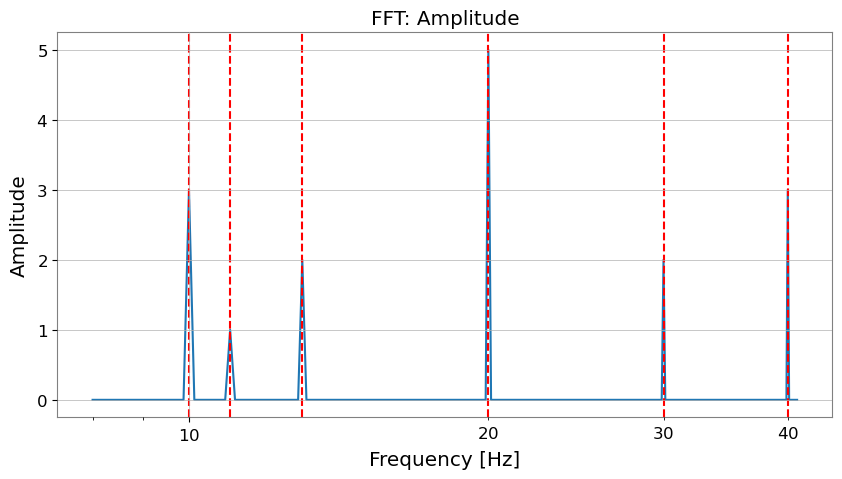

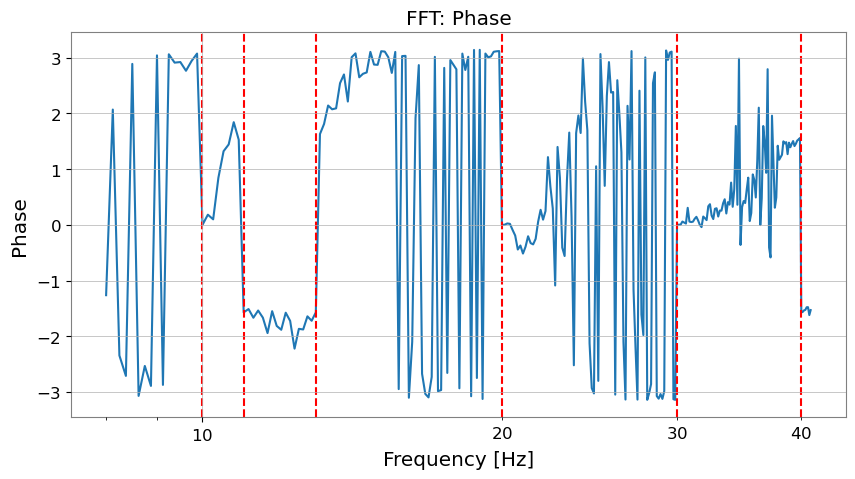

In [5]:
fs = 1024
sig_f = np.fft.rfft(sig)
print(len(sig_f))
print(sig_f)
df = 1/(len(times)/fs)

f_view = [8, 41]
frequencies = np.arange(0, fs/2 + df, df)
fst = int(f_view[0]/df)
fed = int(f_view[1]/df)
plt.figure(figsize=[10,5])
plt.title("FFT: Amplitude")
plt.plot(frequencies[fst:fed], np.abs(sig_f[fst:fed])/len(frequencies))
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude")
plt.xscale('log')
for wave in ['cos', 'sin']:
    for amp, f in zip(amplitudes[wave], modes[wave]):
        if amp != 0:
            plt.axvline(f, c='red', lw=1.5, ls='--')

plt.show()

plt.figure(figsize=[10,5])
plt.title("FFT: Phase")
plt.plot(frequencies[fst:fed], np.angle(sig_f[fst:fed]))
plt.xlabel("Frequency [Hz]")
plt.ylabel("Phase")
plt.xscale('log')
for wave in ['cos', 'sin']:
    for amp, f in zip(amplitudes[wave], modes[wave]):
        if amp != 0:
            plt.axvline(f, c='red', lw=1.5, ls='--')

plt.show()

## Gaussian Noise

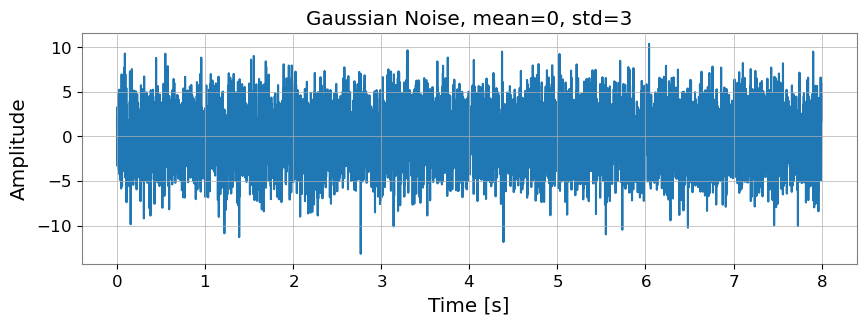

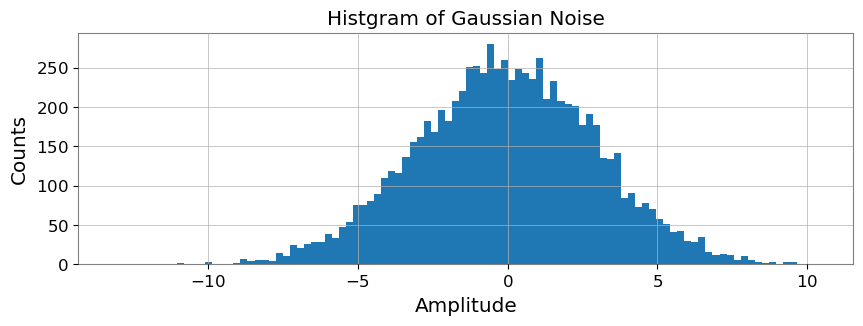

In [6]:
start = 0
end = 8
loc = 0
scale = 3

times, g_sig = gaussian(
    start=start,
    end=end,
    loc=loc,
    scale=scale,
)

plt.figure(figsize=[10,3])
plt.title(f"Gaussian Noise, mean={loc}, std={scale}")
plt.plot(times, g_sig)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

plt.figure(figsize=[10,3])
plt.title("Histgram of Gaussian Noise")
plt.hist(g_sig, bins=100)
plt.xlabel("Amplitude")
plt.ylabel("Counts")
plt.show()

4097
[-575.508746    +0.j         -346.13647604  -7.44656867j
  -88.86410964 +48.85318787j ...   -1.89427018+282.72301985j
 -489.80741086 -37.76242568j    8.11899664  +0.j        ]


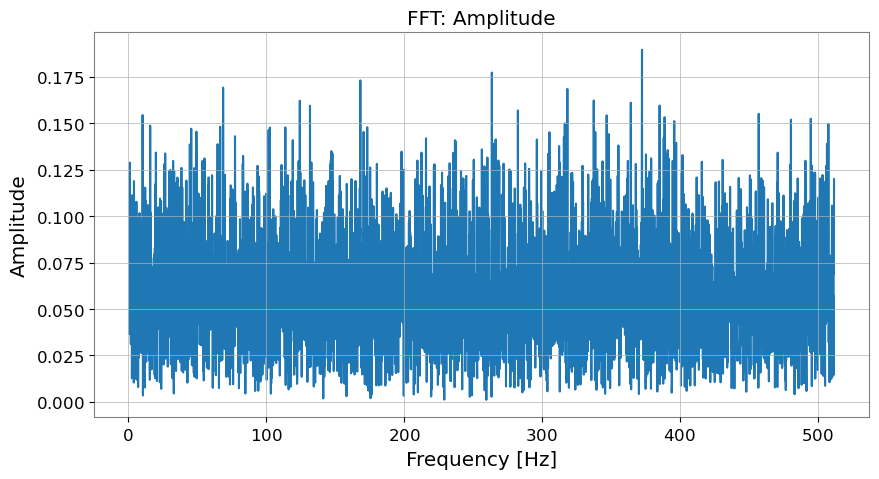

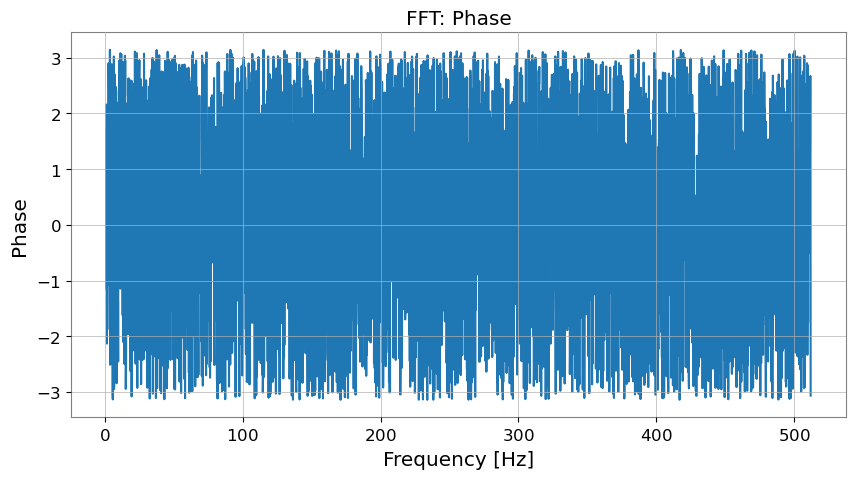

In [7]:
fs = 1024
sig_f = np.fft.rfft(g_sig)
print(len(sig_f))
print(sig_f)
df = 1/(len(times)/fs)

f_view = [1, 512]
frequencies = np.arange(0, fs/2 + df, df)
fst = int(f_view[0]/df)
fed = int(f_view[1]/df)
plt.figure(figsize=[10,5])
plt.title("FFT: Amplitude")
plt.plot(frequencies[fst:fed], np.abs(sig_f[fst:fed])/len(frequencies))
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude")
plt.show()

plt.figure(figsize=[10,5])
plt.title("FFT: Phase")
plt.plot(frequencies[fst:fed], np.angle(sig_f[fst:fed]))
plt.xlabel("Frequency [Hz]")
plt.ylabel("Phase")
plt.show()

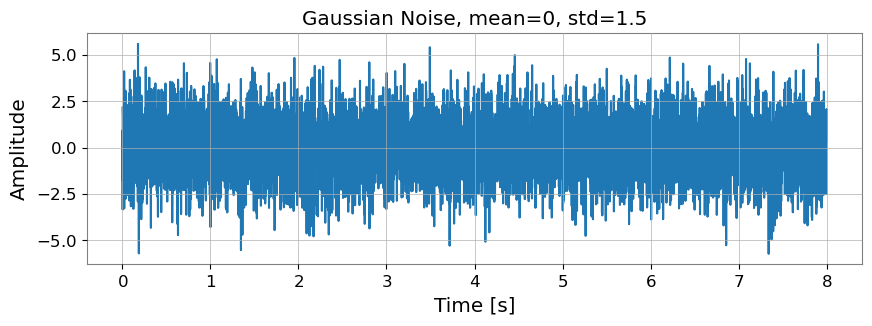

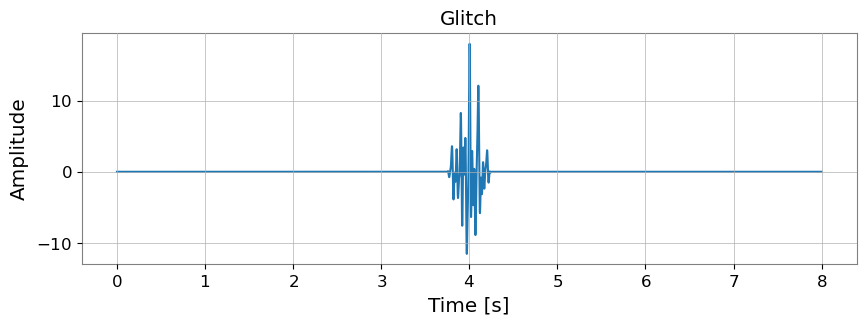

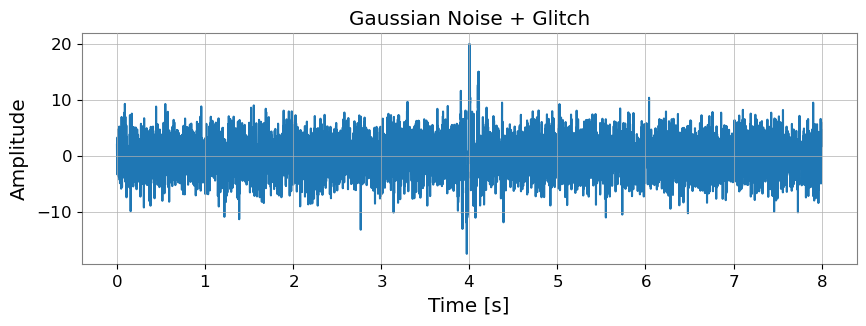

In [8]:
start = 0
end = 8
glitch_st = 3.75
glitch_ed = 4.25
loc = 0
scale = 1.5
fs = 1024

times, g_noise = gaussian(
    start=start,
    end=end,
    loc=loc,
    scale=scale,
)
plt.figure(figsize=[10,3])
plt.title(f"Gaussian Noise, mean={loc}, std={scale}")
plt.plot(times, g_noise)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

glitch_times, glitch = signal(
    start=glitch_st,
    end=glitch_ed,
    amplitudes=amplitudes,
    modes=modes,
    phases=phases,
)
window = np.bartlett(len(glitch))
glitch *= window
pad_earlier = int((glitch_st - start)*fs)
pad_later = int((end - glitch_ed)*fs)
pad_width = (pad_earlier, pad_later)
glitch = np.pad(glitch, pad_width=pad_width, mode='constant', constant_values=(0,0))
glitch *= 1.5
plt.figure(figsize=[10,3])
plt.title(f"Glitch")
plt.plot(times, glitch)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

noise = g_sig + glitch
plt.figure(figsize=[10,3])
plt.title(f"Gaussian Noise + Glitch")
plt.plot(times, noise)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

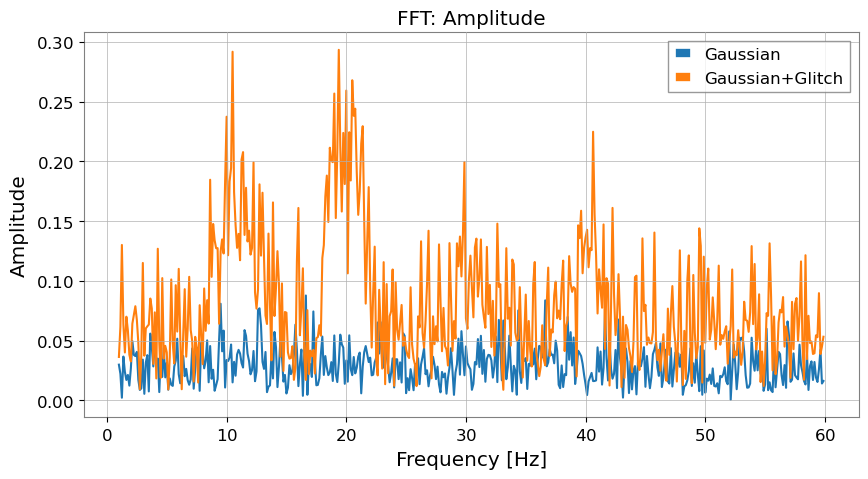

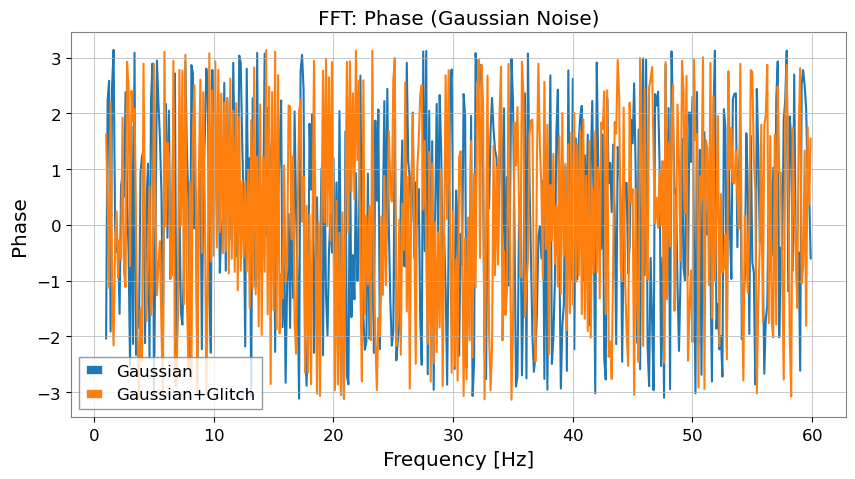

In [9]:
fs = 1024
g_noise_f = np.fft.rfft(g_noise)
# print(len(g_noise_f))
# print(g_noise_f)
noise_f = np.fft.rfft(noise)
# print(len(noise_f))
# print(noise_f)
df = 1/(len(times)/fs)

f_view = [1, 60]
frequencies = np.arange(0, fs/2 + df, df)
fst = int(f_view[0]/df)
fed = int(f_view[1]/df)
plt.figure(figsize=[10,5])
plt.title("FFT: Amplitude")
plt.plot(frequencies[fst:fed], np.abs(g_noise_f[fst:fed])/len(frequencies), label='Gaussian')
plt.plot(frequencies[fst:fed], np.abs(noise_f[fst:fed])/len(frequencies), label='Gaussian+Glitch')
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

plt.figure(figsize=[10,5])
plt.title("FFT: Phase (Gaussian Noise)")
plt.plot(frequencies[fst:fed], np.angle(g_noise_f[fst:fed]), label='Gaussian')
plt.plot(frequencies[fst:fed], np.angle(noise_f[fst:fed]), label='Gaussian+Glitch')
plt.xlabel("Frequency [Hz]")
plt.ylabel("Phase")
plt.legend()
plt.show()

## What's next?
1. System Setup
    - WSL
    - Bash
    - Python Environment
    - Git
2. Fetching Data
    - GWOSC
    - GWpy
    - PyCBC
3. Omicron and Q-transform
4. Machine Learning
    - Pytorch
    - Dataset
    - Model
    - Traning
    - Test

## Querying Science Segments

In [10]:
from gwosc.timeline import get_segments
from gwosc.locate import get_urls

In [11]:
detector = "H1"
sample_rate = 4096
format = "gwf"

start = 1256663442
end = 1256682798
segs = get_segments(f"{detector}_DATA", start, end)
print(segs)

start = segs[0][0]
end = segs[0][1]
print(start, end)

# Getting url of the data, the files can be downloaded using the urls.
urls = get_urls(
    detector=detector,
    start=start,
    end=end,
    sample_rate=sample_rate,
    format=format,
    host="https://gwosc.org",
)
print(urls)

[(1256663443, 1256679418), (1256682796, 1256682798)]
1256663443 1256679418
['https://gwosc.org/archive/data/O3b_4KHZ_R1/1256194048/H-H1_GWOSC_O3b_4KHZ_R1-1256660992-4096.gwf', 'https://gwosc.org/archive/data/O3b_4KHZ_R1/1256194048/H-H1_GWOSC_O3b_4KHZ_R1-1256665088-4096.gwf', 'https://gwosc.org/archive/data/O3b_4KHZ_R1/1256194048/H-H1_GWOSC_O3b_4KHZ_R1-1256669184-4096.gwf', 'https://gwosc.org/archive/data/O3b_4KHZ_R1/1256194048/H-H1_GWOSC_O3b_4KHZ_R1-1256673280-4096.gwf', 'https://gwosc.org/archive/data/O3b_4KHZ_R1/1256194048/H-H1_GWOSC_O3b_4KHZ_R1-1256677376-4096.gwf']


## Fetch Open Data using gwpy

In [12]:
from gwpy.timeseries import TimeSeries
from lalframe.utils import frtools

In [ ]:
ifo = 'L1'
start = 1256655666
duration = 2073
end = start + duration
# Fetch open data from gwosc.org:
ts = TimeSeries.fetch_open_data(
    ifo=ifo,
    start=start,
    end=end,
    sample_rate=4096,
    format='gwf',
)
# Save time series to a gwf file:
ts.write(f"./Data/{ifo[0]}-{ifo}_GWOSC_O3b_4KHZ_R1-{start}-{duration}.gwf", format="gwf")

In [ ]:
gwf_file = "./Data/L-L1_GWOSC_O3b_4KHZ_R1-1256655666-2073.gwf"
# Get channel name from the file:
channel = frtools.get_channels(gwf_file)[0]
print(channel)
# Read time series from the file:
ts = TimeSeries.read(
    source=gwf_file,
    channel=channel,
)

L1:GWOSC-4KHZ_R1_STRAIN
